In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima


In [24]:
df=pd.read_csv('Kiriwaneliya_project.csv')
df.head()




,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,104.699999,11.0,20.2,NaN,NaN
1,2010,February,34.600000,12.0,22.1,NaN,NaN
2,2010,March,128.300001,11.5,23.0,NaN,NaN
3,2010,April,153.200000,13.1,22.5,NaN,NaN
4,2010,May,174.300002,14.1,21.7,NaN,NaN


In [25]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)


In [26]:
df.head()

,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,104.699999,11.0,20.2,NaN,NaN,2010-January
1,2010,February,34.600000,12.0,22.1,NaN,NaN,2010-February
2,2010,March,128.300001,11.5,23.0,NaN,NaN,2010-March
3,2010,April,153.200000,13.1,22.5,NaN,NaN,2010-April
4,2010,May,174.300002,14.1,21.7,NaN,NaN,2010-May


In [27]:
#Slicing dataset
temperature_max=df[["Time","Temp_max"]]
temperature_max.head()

,Time,Temp_max
0,2010-January,20.2
1,2010-February,22.1
2,2010-March,23.0
3,2010-April,22.5
4,2010-May,21.7


In [28]:
temperature_max['Time']=pd.to_datetime(temperature_max['Time'])

C:\Users\wasan\AppData\Local\Temp/ipykernel_8632/653730226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temperature_max['Time']=pd.to_datetime(temperature_max['Time'])


In [29]:
temperature_max.head()

,Time,Temp_max
0,2010-01-01,20.2
1,2010-02-01,22.1
2,2010-03-01,23.0
3,2010-04-01,22.5
4,2010-05-01,21.7


In [30]:
#Checking for missing values
temperature_max.isna().sum()

Time        0
Temp_max    1
dtype: int64

In [31]:
temperature_max.set_index('Time',inplace=True)

In [32]:
temperature_max=temperature_max.resample('MS').first()

In [33]:
#filling missing values
temp=temperature_max.fillna(method="bfill")
temp.head()

,Temp_max
Time,
2010-01-01,20.2
2010-02-01,22.1
2010-03-01,23.0
2010-04-01,22.5
2010-05-01,21.7


In [34]:
#Rename column
temp = temp.rename(columns = {'Temp_max': 'Temperature Max'}, inplace = False)
temp.head()

,Temperature Max
Time,
2010-01-01,20.2
2010-02-01,22.1
2010-03-01,23.0
2010-04-01,22.5
2010-05-01,21.7


In [35]:
#Checking for missing values
temp.isna().sum()

Temperature Max    0
dtype: int64

<AxesSubplot:xlabel='Time'>

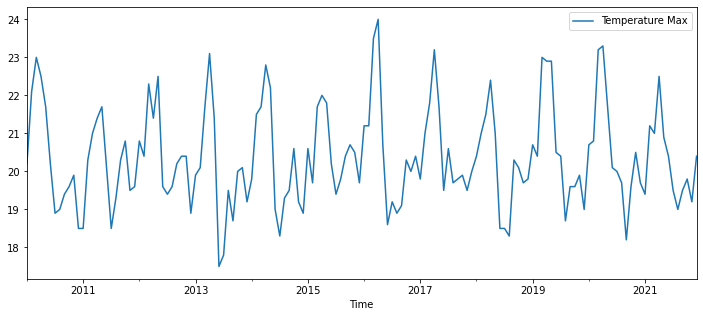

In [36]:
temp.plot(figsize=(12,5))

It can't be cleary identified trend or seasonality.

In [37]:
### ADF Test
test_result=adfuller(temp['Temperature Max'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(rainfall):
    result=adfuller(rainfall)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(temp['Temperature Max'])

ADF Test Statistic : -3.1351059531011245
p-value : 0.0240619366974822
#Lags Used : 13
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [38]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(temp['Temperature Max'])

KPSS Statistic: 0.07300836574751086
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [39]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(temp['Temperature Max'].astype(float))
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -5.017
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# ACF and PACF plots

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


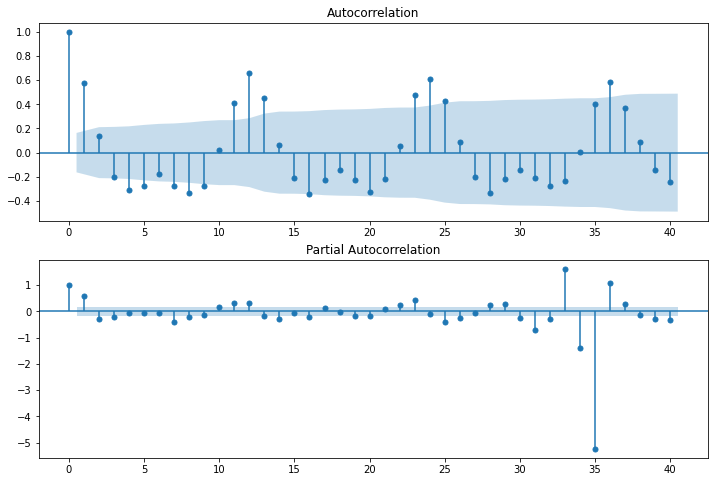

In [40]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp['Temperature Max'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp['Temperature Max'],lags=40,ax=ax2)

In [41]:

#According to PACF and ACF plots,better to start with p=2 d=0 and q=1 can be considered.
arima_model=auto_arima(temp['Temperature Max'].astype(float),start_p=0,start_q=0,max_p=3,max_q=2,start_P=0,start_D=0,start_Q=0,max_P=3,max_D=1,max_Q=1,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=True,random_state=20,n_fits=80,maxiter=70)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=489.421, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=371.958, Time=0.93 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=399.802, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1279.287, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=433.239, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=365.460, Time=1.07 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=inf, Time=2.98 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=354.017, Time=4.10 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(2,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=4.46 sec
 ARIMA(1,0,1)(3,0,1)[12] intercept   : AIC=344.439, Time=4.58 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(1,0,1)(3,0,0)[12] intercept   : AIC=inf, Time=3.8

# Forecast using the model

In [42]:
model=sm.tsa.statespace.SARIMAX(temp['Temperature Max'].astype('float'),order=(1, 0, 1),seasonal_order=(3,0,1,12))
results=model.fit()
results.summary()

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    Temperature Max   No. Observations:                  144
Model:             SARIMAX(1, 0, 1)x(3, 0, 1, 12)   Log Likelihood                -174.741
Date:                            Tue, 26 Apr 2022   AIC                            363.482
Time:                                    02:21:42   BIC                            384.270
Sample:                                01-01-2010   HQIC                           371.929
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9938      0.010     96.982      0.000       0.974       1.014
ma.L1         -0.6819      0.071     -9.608      0.000      -0.821      -0.543
ar.S.L12       0.6823      0.152      4.500      0.000       0.385       0.980
ar.S.L24      -0.0308      0.119     -0.259      0.796      -0.264       0.202
ar.S.L36       0.3207      0.106      3.036      0.002       0.114       0.528
ma.S.L12      -0.4940      0.150     -3.283      0.001      -0.789      -0.199
sigma2         0.5370      0.066      8.193      0.000       0.409       0.665
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):                 3.14
Prob(Q):                              0.34   Prob(JB):                         0.21
Heteroskedasticity (H):               0.89   Skew:                            -0.28
Prob(H) (two-sided):                  0.70   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
beg_dt='2017-01-01'
end_dt='2025-12-01'

In [ ]:
#results.predict(start=beg_dt,end=end_dt,dynamic=True)

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='Time'>

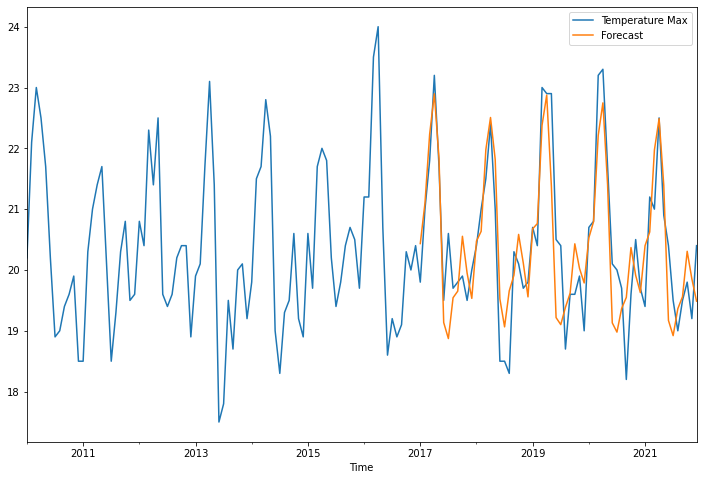

In [44]:
temp['Forecast']=results.predict(start=beg_dt,end=end_dt,dynamic=True)
temp[['Temperature Max','Forecast']].plot(figsize=(12,8))

In [21]:
temp.tail()


,Temperature Max,Forecast
Time,,
2021-08-01,19.0,17.087390
2021-09-01,19.5,17.333136
2021-10-01,19.8,17.470516
2021-11-01,19.2,17.974579
2021-12-01,20.4,NaN
